In [1]:
# =============================================================================
# Commercial Banking Employment vs. Presidential Party
# Author: [Your Name]
# Description:
#   This mini project looks at whether commercial banking employment
#   tends to be higher under Republican or Democratic presidents.
#   We'll use data from the Federal Reserve (FRED) and merge it with
#   U.S. presidential party information to analyze trends and test
#   if there’s any statistically significant difference.
# =============================================================================

# --- Import necessary libraries ---
from fredapi import Fred              # for pulling data from FRED
import pandas as pd                   # for data manipulation
import numpy as np                    # for numerical operations
import matplotlib.pyplot as plt       # for visualization
from scipy.stats import ttest_ind     # for t-test
import statsmodels.formula.api as smf # for regression analysis

# Make plots a bit bigger and easier to read
plt.rcParams["figure.figsize"] = (12, 6)

# --- Step 1: Pull Employment Data from FRED ---
# Source: Bureau of Labor Statistics, "All Employees: Commercial Banking"
# Series ID: CEU5552211001
# Unit: Thousands of Persons (Monthly)
fred = Fred(api_key='2977cee9deb26f12ad01e523616d0574')

# Pull monthly data from 1960–2025
temp = fred.get_series('CEU5552211001', observation_start='1960-01-01', observation_end='2025-07-01')

# Convert the data to a DataFrame for easier analysis
df = pd.DataFrame({'Date': pd.to_datetime(temp.index), 'Employment': temp.values})
df = df.sort_values('Date').reset_index(drop=True)

# Quick look at the first few rows
print(df.head(), "\n")


        Date  Employment
0 1990-01-01      1451.0
1 1990-02-01      1451.2
2 1990-03-01      1450.2
3 1990-04-01      1447.5
4 1990-05-01      1448.8 



In [2]:
# --- Step 2: Add Presidential Party Information ---
# Manually create a list of U.S. presidents with their term start, end, and political party.
# We'll merge this information with our employment data to label each observation by party.
terms = [
    ('1953-01-20', '1961-01-20', 'Republican'),  # Eisenhower
    ('1961-01-20', '1963-11-22', 'Democrat'),    # Kennedy
    ('1963-11-22', '1969-01-20', 'Democrat'),    # Johnson
    ('1969-01-20', '1974-08-09', 'Republican'),  # Nixon
    ('1974-08-09', '1977-01-20', 'Republican'),  # Ford
    ('1977-01-20', '1981-01-20', 'Democrat'),    # Carter
    ('1981-01-20', '1989-01-20', 'Republican'),  # Reagan
    ('1989-01-20', '1993-01-20', 'Republican'),  # George H. W. Bush
    ('1993-01-20', '2001-01-20', 'Democrat'),    # Clinton
    ('2001-01-20', '2009-01-20', 'Republican'),  # George W. Bush
    ('2009-01-20', '2017-01-20', 'Democrat'),    # Obama
    ('2017-01-20', '2021-01-20', 'Republican'),  # Trump
    ('2021-01-20', '2025-01-20', 'Democrat')     # Biden
]

# Convert to DataFrame
party_df = pd.DataFrame(terms, columns=['Start', 'End', 'Party'])
party_df['Start'] = pd.to_datetime(party_df['Start'])
party_df['End']   = pd.to_datetime(party_df['End'])
party_df = party_df.sort_values('Start').reset_index(drop=True)

# Merge presidential party with employment data
# We’ll use merge_asof to match each employment date with the president in office.
df = pd.merge_asof(df.sort_values('Date'), party_df[['Start', 'End', 'Party']].sort_values('Start'),
                   left_on='Date', right_on='Start', direction='backward')

# Only keep rows that fall within the president’s term
df = df[df['Date'] <= df['End']].reset_index(drop=True)

# Create a dummy variable (1 = Republican, 0 = Democrat)
df['Republican'] = (df['Party'] == 'Republican').astype(int)

# Extract Year and Month to use later
df['Year']  = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

print("Data after merging party information:")
print(df.head(), "\n")

Data after merging party information:
        Date  Employment      Start        End       Party  Republican  Year  \
0 1990-01-01      1451.0 1989-01-20 1993-01-20  Republican           1  1990   
1 1990-02-01      1451.2 1989-01-20 1993-01-20  Republican           1  1990   
2 1990-03-01      1450.2 1989-01-20 1993-01-20  Republican           1  1990   
3 1990-04-01      1447.5 1989-01-20 1993-01-20  Republican           1  1990   
4 1990-05-01      1448.8 1989-01-20 1993-01-20  Republican           1  1990   

   Month  
0      1  
1      2  
2      3  
3      4  
4      5   



In [3]:
# --- Step 3: Summary Statistics by Party ---
# Compare the average, standard deviation, and range of employment under each party.
summary = (df.groupby('Party')['Employment']
             .agg(mean='mean', std='std', min='min', max='max', count='count')
             .round(2))
print("Summary statistics by party:")
print(summary, "\n")

# Optional: also look at averages by administration term
admin_stats = (df.assign(Admin=lambda x: x['Start'].dt.strftime('%Y-%m-%d') + ' ' + x['Party'])
                 .groupby(['Start', 'End', 'Party'])
                 .agg(
                     months=('Employment', 'size'),
                     mean_level=('Employment', 'mean'),
                     level_start=('Employment', 'first'),
                     level_end=('Employment', 'last')
                 )
                 .assign(
                     total_change=lambda d: d['level_end'] - d['level_start'],
                     avg_monthly_change=lambda d: d['total_change'] / d['months']
                 )
                 .reset_index())
print("Per-administration averages and changes:")
print(admin_stats.round(2), "\n")

Summary statistics by party:
               mean    std     min     max  count
Party                                            
Democrat    1363.38  18.57  1310.7  1406.6    240
Republican  1388.15  30.19  1315.6  1463.3    181 

Per-administration averages and changes:
       Start        End       Party  months  mean_level  level_start  \
0 1989-01-20 1993-01-20  Republican      37     1411.96       1451.0   
1 1993-01-20 2001-01-20    Democrat      96     1354.13       1372.4   
2 2001-01-20 2009-01-20  Republican      96     1380.86       1315.6   
3 2009-01-20 2017-01-20    Democrat      96     1365.12       1394.6   
4 2017-01-20 2021-01-20  Republican      48     1384.36       1372.9   
5 2021-01-20 2025-01-20    Democrat      48     1378.41       1372.7   

   level_end  total_change  avg_monthly_change  
0     1375.3         -75.7               -2.05  
1     1315.1         -57.3               -0.60  
2     1403.8          88.2                0.92  
3     1374.1         -20.5 

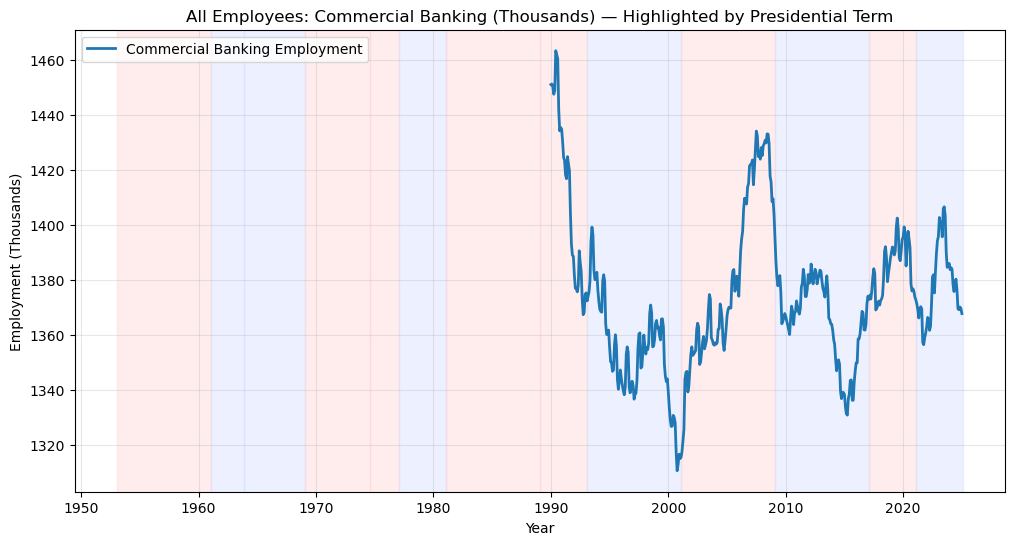

In [4]:
# --- Step 4: Visualize Employment Trends ---
# We'll plot the employment data and shade the background for each presidential term.
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Employment'], linewidth=2, label='Commercial Banking Employment')
ax.set_title('All Employees: Commercial Banking (Thousands) — Highlighted by Presidential Term')
ax.set_xlabel('Year')
ax.set_ylabel('Employment (Thousands)')

# Shade background by party: light red for Republicans, light blue for Democrats
for _, row in party_df.iterrows():
    color = (1, 0.8, 0.8, 0.35) if row['Party'] == 'Republican' else (0.8, 0.85, 1, 0.35)
    ax.axvspan(row['Start'], row['End'], color=color)

ax.grid(True, alpha=0.3)
ax.legend(loc='upper left')
plt.show()

In [5]:
# --- Step 5: Mean Difference Test (Welch’s t-test) ---
# Test whether the mean level of employment differs between parties.
rep = df.loc[df['Party'] == 'Republican', 'Employment']
dem = df.loc[df['Party'] == 'Democrat',   'Employment']

# Welch’s t-test (does not assume equal variances)
t_stat, p_val = ttest_ind(rep, dem, equal_var=False, nan_policy='omit')

print("Welch t-test comparing mean employment (Republican vs. Democrat):")
print(f"T-statistic = {t_stat:.3f}, p-value = {p_val:.4f}")
print(f"Mean (Republican): {rep.mean():.2f}")
print(f"Mean (Democrat)  : {dem.mean():.2f}\n")

# --- Step 6: Simple Regression Analysis ---
# We'll regress Employment on a Republican dummy, controlling for time (Year)
# and seasonal effects (Month fixed effects).
# This helps control for long-term growth and seasonality.

model = smf.ols('Employment ~ Republican + Year + C(Month)', data=df).fit(cov_type='HC1')  # robust SEs
print(model.summary())

# --- Notes for interpretation ---
# The "Republican" coefficient tells us the *average difference* in employment levels
# between Republican and Democratic administrations, after controlling for time trend and month.
# However, correlation ≠ causation! The economy, crises, and policy shocks all influence employment.

Welch t-test comparing mean employment (Republican vs. Democrat):
T-statistic = 9.734, p-value = 0.0000
Mean (Republican): 1388.15
Mean (Democrat)  : 1363.38

                            OLS Regression Results                            
Dep. Variable:             Employment   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     12.04
Date:                Sun, 05 Oct 2025   Prob (F-statistic):           3.05e-22
Time:                        21:11:31   Log-Likelihood:                -1930.6
No. Observations:                 421   AIC:                             3889.
Df Residuals:                     407   BIC:                             3946.
Df Model:                          13                                         
Covariance Type:                  HC1                                         
                     coef    std err          z    